import necessarry modules

In [1]:
path_reg = r'D:\uni\2-Msc\term 1\neural control\homeworks\Part2\Time-series\Video surveillance Dataset.xlsx'
path_class = r'D:\uni\2-Msc\term 1\neural control\homeworks\Part2\Classification\dataset-iris.xlsx'

## **import**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-dark')
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.manifold import TSNE

## **one hot method**

In [3]:
# create one hot encoded data and unique labels
def one_hot_encoder(data) :
  unique_labels, labels_mapping = np.unique(data[:,-1], return_inverse=True)
  identity_matrix = np.eye(len(unique_labels))
  one_hot_encoded = identity_matrix[labels_mapping]
  return one_hot_encoded, unique_labels
# decode one hotted data
def decode_one_hot(rows, labels):
  indices = np.argmax(rows, axis=1)
  decoded_labels = np.array(labels)[indices]
  return decoded_labels

# change some classes, noisy targets
def add_noise_to_targets(targets, noise_prob):
    # Copy the original targets to avoid modifying them directly
    noisy_targets = np.copy(targets)

    # Determine the number of rows to modify based on the noise probability
    num_rows_to_modify = int(noise_prob * targets.shape[0])

    # Generate random indices for the rows to modify
    indices_to_modify = np.random.choice(targets.shape[0], size=num_rows_to_modify, replace=False)

    # Generate random new classes for the modified rows
    num_classes = targets.shape[1]
    new_classes = np.random.randint(0, num_classes, size=num_rows_to_modify)

    # Update the noisy targets with the new classes at the selected rows
    noisy_targets[indices_to_modify] = np.eye(num_classes)[new_classes]

    return noisy_targets

## **creating time series**

In [4]:
def time_series_create(data_column, n_feature):
    data_column = np.ravel(data_column)
    num_rows = np.size(data_column, axis=0)
    seriesed_data = np.zeros((num_rows - n_feature + 1, n_feature))
    for i in range(n_feature):
        seriesed_data[:, i] = data_column[i:num_rows - n_feature + i + 1]
    return seriesed_data

array [0., 1., 2., 3., 4.] would be:
array([[0., 1., 2.],
       [1., 2., 3.],
       [2., 3., 4.]]).
this function only accept a column vector

## **activation functions**

In [5]:
############################### Leaky Rectified Linear Unit :
def leaky_Relu(net, alpha) :
  return np.where(net > 0, net, alpha * net)
# O = net            if net > 0
# O = alpha * net    if net < 0

############################### Exponential Linear Unit :
def elu(net, alpha, landa=1) :
  return landa * np.where(net > 0, net, alpha * (np.exp(net) - 1))
# O = net                       if net > 0
# O = alpha * (exp(net) - 1)    if net < 0

############################### sigmoid :
def sigmoid(net) :
  return 1 / (1 + np.exp(-net))
############################### flexible sigmoid :
def flex_sigmoid(net, alpha) :
  return 2 * np.abs(alpha) / (1 + np.exp(-alpha * net))

############################### tanh :
def tanh(net, alpha=1) :
  if np.abs(alpha) > 0.0001 :
   return 1 / alpha * np.tanh(alpha * net)
  else :
    return 0.5 * net

############################### Rectified Linear Units :
def relu(net) :
  return np.maximum(0, net)
# O = net    if net > 0
# O = 0      if net < 0

############################### softmax :
def softmax(net) :
   # Subtracting the maximum value to avoid overflow
    net -= np.max(net)
    exp_z = np.exp(net)
    softmax_probs = exp_z / np.sum(exp_z)
    return softmax_probs
# O = exp(net) / sum(exp(net))

## **activation functions derivatives**

In [6]:
############################### Leaky Rectified Linear Unit :
def leaky_relu_derivative(net ,alpha) :
  return np.where(net > 0, 1, alpha)
# F_prime = 1        if net > 0
# F_prime = alpha    if net < 0

############################### Exponential Linear Unit :
def elu_derivative(net, alpha, landa=1) :
  return landa * np.where(net > 0, 1, np.exp(net) * alpha)
# F_prime = 1                   if net > 0
# F_prime = alpha * exp(net)    if net < 0

############################### sigmoid :
def sigmoid_derivative(net) :
  return sigmoid(net) * (1 - sigmoid(net))

def flex_sigmoid_derivative(net, alpha) :
  exxp = np.exp(alpha * net)
  return -2 * alpha * np.abs(alpha) * exxp / (1 + exxp) ** 2

############################### tanh :
def tanh_derivative(net, alpha=1) :
  return 1 / np.cosh(alpha * net) ** 2
############################### Rectified Linear Units :
def relu_derivative(net) :
  return np.where(net > 0, 1, 0)
# O = 1    if net > 0
# O = 0    if net < 0

############################### softmax :
def softmax_derivative(net) :
  z = softmax(net)
  n = np.size(z, axis = 0)
  M = np.repeat(z,n, axis=1)
  I = np.eye(n)
  return M * (I - M)
# zi * zj          if i != j
# zi * (1 - zj)    if j = i

## **flexible activation function star derivative**

In [7]:
def sigmoid_star(net, alpha) :
    if np.abs(alpha) != 0 :
     gnet = alpha * net
     exxp = np.exp(gnet)
     return 2 * (alpha * exxp * (1-gnet) +alpha) / (np.abs(alpha) * (exxp + 1) ** 2)
    else :
       return 0

def tanh_star(net, alpha) :
    if np.abs(alpha) > 0.0001 :
     gnet = alpha * net
     out = gnet * (1 / np.cosh(gnet) ** 2) - np.tanh(gnet)
     out /= alpha ** 2
    else :
       out = 0
    return out

def leaky_Relu_star(net) :
   return np.where(net > 0, 0, net)

def elu_star(net, alpha, landa) :
   out_alpha = landa * np.where(net > 0, 0, np.exp(net) - 1)
   out_landa = np.where(net > 0, net, alpha * (np.exp(net) - 1))
   return out_alpha, out_landa


## **data normalization**

In [8]:
def normalizeData_0TO1(data, return_param=False) :
  min_vals = np.min(data, axis=0)
  max_vals = np.max(data, axis=0)
  normal_data = (data - min_vals) / (max_vals - min_vals)
  if return_param :
   return normal_data, min_vals, max_vals
  else :
    return normal_data
# data would be between 0 and +1

def normalizeData_neg1TOpos1(data, return_param=False) :
  min_vals = np.min(data, axis=0)
  max_vals = np.max(data, axis=0)
  normal_data = 2 * (data - min_vals) / (max_vals - min_vals) - 1
  if return_param :
   return normal_data, min_vals, max_vals
  else :
    return normal_data
# data would be between -1 and +1

## **network output denormalization**

In [9]:
def denormalize_0TO1(normal_data, min_vals, max_vals) :
  normal_data *= (max_vals - min_vals)
  normal_data += min_vals
  return normal_data
# denormalize from [0, 1] normalized data

def denormalize_neg1TOpos1(normal_data, min_vals, max_vals) :
  normal_data += 1
  normal_data /= 2
  normal_data *= (max_vals - min_vals)
  normal_data += min_vals
  return normal_data
# denormalize from [-1, 1] normalized data

## **functions for MSE**

In [10]:
def MSE_calculate(targets, results, one_mse=True) :
    square_error = (targets - results) ** 2
    mse = np.ravel(np.mean(square_error, axis=0))
    if one_mse :
       mse = float(np.mean(mse))
    return mse

def update_plot_MSE(mse_train, mse_test, ite=0, epoch=0, figsize=(6, 4), one_mse=True):
   mse_test = np.array(mse_test, dtype='float32')
   mse_train = np.array(mse_train, dtype='float32')
   x, y = figsize
   fig, axes = plt.subplots(1, 2, figsize=(x, y))
   fig.suptitle('MSE plot')
   if one_mse:
        axes[1].semilogy(np.arange(1, ite+1), mse_test, label='MSE test', color='orange')
        axes[0].semilogy(np.arange(1, ite+1), mse_train, label='MSE train', color='blue')
        axes[0].legend()
        axes[1].legend()
   elif np.ndim(mse_test) > 1:
        k = 0
        for i in mse_test.swapaxes(1,0) :
            k += 1
            axes[1].semilogy(np.arange(1, ite+1), i, label=f'output {k} MSE test')
            axes[1].legend(fontsize='small')
        k = 0
        for i in mse_train.swapaxes(1,0) :
            k += 1
            axes[0].semilogy(np.arange(1, ite+1), i, label=f'output {k} MSE train')
            axes[0].legend(fontsize='small')
   try :
     axes[0].set_title(f'train MSE, last epoch : {np.mean(mse_train[-1]):.5f}')
     axes[1].set_title(f'test MSE, last epoch : {np.mean(mse_test[-1]):.5f}')
   except :
       pass
   for ax in axes :
     ax.minorticks_on()
     ax.grid(which='minor', linestyle='-', linewidth='0.5', color='gray', axis='y')
     ax.tick_params(axis='y', which='minor', labelsize=8)
     ax.tick_params(axis='y', which='major', labelsize=10)
     ax.set_xlabel(f'epochs ({ite}/{epoch})')
     ax.set_ylabel('loss')
   
   fig.tight_layout()
   plt.show()
   clear_output(wait=True)  # Clear the previous output



## **regression plot**

In [11]:
def plot_regression(train_target, train_predict, test_target, test_predict, is0to1=True, figsize=(8, 6)) :
  k = 0
  n_output = np.size(test_target, axis=1)
  for i in range(n_output):
    k += 1
    slope, intercept = np.polyfit(train_target[:, i], train_predict[:, i], deg=1)

    x, y = figsize
    fig, axes = plt.subplots(1, 2, figsize=(x, y))
    fig.suptitle('regression plot')

    axes[0].scatter(train_target[:, i], train_predict[:, i], edgecolor='blue',\
                     alpha=0.7, facecolor='none', label=f'scattered data output {k}')
    title = f'output {k}: train, regression coefficient = {round(slope, 4)}'
    axes[0].set_title(title, fontsize='small')
    axes[1].scatter(test_target[:, i], test_predict[:, i], edgecolor='blue',\
                     alpha=0.7, facecolor='none', label=f'scattered data output {k}')
    title = f'output {k}: test, regression coefficient = {round(slope, 4)}'
    axes[1].set_title(title, fontsize='small')
    if is0to1 :
      axes[1].plot([0,1], [0, 1], color='red', label='Y=X line')
      axes[0].plot([0,1], [0, 1], color='red', label='Y=X line')
      axes[1].plot([0, 1], [intercept, intercept + slope], color='black',\
                    linestyle='dotted', label='regression line')
      axes[0].plot([0, 1], [intercept, intercept + slope], color='black',\
                    linestyle='dotted', label='regression line')
    else :
      axes[0].plot([-1,1], [-1, 1], color='red', label='Y=X line')
      axes[1].plot([-1,1], [-1, 1], color='red', label='Y=X line')
      axes[1].plot([-1, 1],[intercept - slope, intercept + slope], color='black',\
                linestyle='dotted', label='regression line')
      axes[0].plot([-1, 1],[intercept - slope, intercept + slope], color='black',\
                linestyle='dotted', label='regression line')

    for ax in axes :
     ax.minorticks_on()
     ax.grid(which='minor', linestyle='-', linewidth='0.5', color='gray', axis='both', alpha=0.5)
     ax.tick_params(axis='y', which='minor', labelsize=8)
     ax.tick_params(axis='y', which='major', labelsize=10)
     ax.set_xlabel('expected values')
     ax.set_ylabel('predicted values')
     ax.set_aspect('equal')
     ax.legend(fontsize='x-small')

    fig.tight_layout()
    plt.show()
    fig.clf()

## **visualize outputs**

In [12]:
def plot_outputs(target, output, figsize=(8,6)) :
    x, y = figsize
    k = 0
    for i, j in zip(target.swapaxes(1, 0), output.swapaxes(1, 0)) :
     k += 1
     fig = plt.figure(figsize=(x, y))
     plt.clf()
     plt.plot(i, color='blue', label='actual data')
     plt.plot(j, color='red', label='predicted data', linestyle='dotted')
     plt.minorticks_on()
     plt.grid(which='minor', linestyle='-', linewidth='0.5', color='gray')
     plt.tick_params(axis='y', which='minor', labelsize=8)
     plt.tick_params(axis='y', which='major', labelsize=10)
     plt.tick_params(labelbottom=False)
     plt.legend(fontsize='small')
     title = f'curve fitting for output {k}'
     plt.title(title)
     print('')
     plt.show()

## **cross entropy loss**

In [13]:
def cross_entropy_calculate(target, results) :
   return float(np.mean(-np.sum(target * np.log(results + 1e-15), axis=1)))

def update_plot_entropy(loss_train, loss_test, ite=0, epoch=0, figsize=(8,6)) :
   x, y = figsize
   fig, axes = plt.subplots(1, 2, figsize=(x, y))
   fig.suptitle('cross entropy plot')
   axes[1].semilogy(np.arange(1, ite+1), loss_test, color='orange', label='test cross entropy')
   axes[0].semilogy(np.arange(1, ite+1), loss_train, color='blue', label='train cross entropy')
   try :
     axes[0].set_title(f'train loss, last epoch : {np.mean(loss_train[-1]):.4f}')
     axes[1].set_title(f'test loss, last epoch : {np.mean(loss_test[-1]):.4f}')
   except :
      pass
   for ax in axes :
    ax.minorticks_on()
    ax.grid(which='minor', linestyle='-', linewidth='0.5', color='gray', axis='y')
    ax.tick_params(axis='y', which='minor', labelsize=8)
    ax.tick_params(axis='y', which='major', labelsize=10)
    ax.set_xlabel(f'epochs ({ite}/{epoch})')
    ax.set_ylabel('loss')
    ax.legend()
   fig.tight_layout()
   plt.show()
   clear_output(wait=True)  # Clear the previous output

## **confusion matrix**

In [14]:
def plot_confusion_matrix(targets, predictions, classes, title, normalize=True, figsize=(8,6), cmap=plt.cm.Blues):
    # Calculate confusion matrix
    cm = confusion_matrix(np.argmax(targets, axis=1), np.argmax(predictions, axis=1))

    # Normalize confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    x, y = figsize
    plt.figure(figsize=(x, y))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

## **visualize classes**

In [15]:
def visualize_data(features, targets, predicted_data, figsize=(8, 4), n_components=2, random_state=42, perplexity=30):
    features_num = np.size(features, axis=1)
    x, y = figsize
    fig, axs = plt.subplots(1, 2, figsize=(x, y))

    predicted_classes = np.argmax(predicted_data, axis=1)
    predicted_data_onehot = np.zeros_like(predicted_data)
    predicted_data_onehot[np.arange(len(predicted_data)), predicted_classes] = 1

    if features_num <= 2:
        # 2D scatter plot for two classes
        axs[0].scatter(features[:, 0], features[:, 1], c=targets[:, 0], cmap='coolwarm', marker='o', label='True Classes')
        axs[1].scatter(features[:, 0], features[:, 1], c=predicted_data_onehot[:, 0], cmap='cividis', marker='o', label='Predicted Classes')
        fig.suptitle('visualizing classification performance')
    else:
        # Use t-SNE for more than two classes
        tsne = TSNE(n_components=n_components, random_state=random_state, perplexity=perplexity)
        features_tsne = tsne.fit_transform(features)

        axs[0].scatter(features_tsne[:, 0], features_tsne[:, 1], c=targets.argmax(axis=1), cmap='coolwarm', marker='o', label='True Classes')
        axs[1].scatter(features_tsne[:, 0], features_tsne[:, 1], c=predicted_data_onehot.argmax(axis=1), cmap='cividis', marker='o', label='Predicted Classes')
        fig.suptitle('t-SNE classification performance')

    axs[0].set_title('Actual Data')
    axs[0].tick_params(axis='both', which='both', bottom=False, top=False, left=False,\
                            right=False, labelbottom=False, labelleft=False)
    axs[0].minorticks_on()
    axs[0].grid(True, which='both', alpha=0.2, color='gray')

    axs[1].set_title('Predicted Data')
    axs[1].tick_params(axis='both', which='both', bottom=False, top=False, left=False,\
                            right=False, labelbottom=False, labelleft=False)
    axs[1].minorticks_on()
    axs[1].grid(True, which='both', alpha=0.2, color='gray')



    plt.tight_layout()
    print('')
    plt.show()

## **initializing network**

In [16]:
# initialize weights out of init dunder to make code look clean and easy for maintenance
def weight_init(layers, data_type) :
  size = int(np.size(layers)) - 1    # number of layers, except for input
  # let's choose an appropriate variance for normal distribution to initialize weights
  var = np.sqrt(2 / (layers[0] + layers[-1]))
  # weights matrix and bias vectors for each layer have a different shape to the others, so assign it using lists
  weights = []
  bias = []
  for i in range(size) :
    sz1 = (layers[i+1], layers[i])    # each row is for one neuron
    weights.append(np.random.normal(0, var, sz1).astype(data_type))
    sz2 = (layers[i+1], 1)
    bias.append(np.zeros(sz2).astype(data_type))
  return weights, bias


#  initialize nets out of init dunder to make code look clean and easy for maintenance
def net_out_init(layers, data_type) :
  size = int(np.size(layers)) - 1    # number of layers, except for input
  Out = []
  net = []
  for i in range(size) :
      sz1 = (layers[i+1], 1)
      net.append(np.zeros(sz1).astype(data_type))
      sz2 = (layers[i], 1)
      Out.append(np.zeros(sz2).astype(data_type))
  sz2 = (layers[-1], 1)
  Out.append(np.zeros(sz2))
  return net, Out

def activation_init(lyr, act_fun) :
   lenn = len(act_fun)
   for i in range(lenn) :
      if 'flex_' in act_fun[i] :
         func = []
         func.append(act_fun[i])
         func *= lyr[i+1]
         act_fun.pop(i)
         act_fun.insert(i, func)
   return act_fun

def per_grad_init(weigthss, lyr, act_fun) :
   weigths = weigthss.copy()
   k = 0
   bias = []
   for i in weigths :
      weigths[k] *= 0
      bias.append(weigths[k][:,0])
      k += 1
   leng = len(act_fun)
   grad_f_g, grad_f_lan = [], []
   for i in range(leng) :
      if type(act_fun[i]) is not list:
         grad_f_g.append(np.array([]))
         grad_f_lan.append(np.array([]))
      elif 'flex_elu' in act_fun[i][0] :
         grad_f_g.append(np.zeros((lyr[i+1], 1)))
         grad_f_lan.append(np.zeros((lyr[i+1], 1)))
      else :
         grad_f_g.append(np.zeros((lyr[i+1], 1)))
         grad_f_lan.append(np.array([]))
   return [weigths, bias, grad_f_g, grad_f_lan]

## **choose activation funtion**

In [17]:
def net2out(net, layer_function) :
      if 'flex' in layer_function[0] :
       leng = len(layer_function)
       out = np.zeros((leng, 1))
       for i in range(leng):

        if 'flex_leaky_relu' == layer_function[i][:15] :
          alpha = float(layer_function[i][15:])
          out[i] = leaky_Relu(net[i], alpha)

        elif 'flex_elu' == layer_function[i][:8]:
          params = layer_function[i][8:]
          alpha, landa = params.split('#')
          alpha, landa = float(alpha), float(landa)
          out[i] = elu(net[i], alpha, landa)

        elif 'flex_sigmoid' == layer_function[i][:12] :
          alpha = float(layer_function[i][12:])
          out[i] = flex_sigmoid(net[i], alpha)

        elif 'flex_tanh' == layer_function[i][:9] :
          alpha = float(layer_function[i][9:])
          out[i] = tanh(net[i], alpha)

      else :
       if 'leaky_relu' == layer_function[:10] :
         alpha = float(layer_function[10:])
         out = leaky_Relu(net, alpha)

       elif 'elu' == layer_function[:3]:
         alpha = float(layer_function[3:])
         out = elu(net, alpha)

       elif 'sigmoid' == layer_function :
         out = sigmoid(net)

       elif 'tanh' == layer_function :
         out = tanh(net)

       elif 'relu' ==layer_function :
         out = relu(net)

       elif 'lin' == layer_function :
         out = net.copy()

       elif 'softmax' == layer_function :
         out = softmax(net)
      
       elif 'gelu' == layer_function :
         out = 0.5 * net * (1 + np.tanh(np.sqrt(2 / np.pi) * (net + 0.044715 * net**3)))

       else :
         raise('your activation function is not supported')
      return out

## **choose activation function derivative**

In [18]:
def net2Fprime(net, layer_function) :
      if 'flex' in layer_function[0] :
       leng = len(layer_function)
       out = np.zeros((leng, 1))
       for i in range(leng):

        if 'flex_leaky_relu' == layer_function[i][:15] :
          alpha = float(layer_function[i][15:])
          out[i] = leaky_relu_derivative(net[i], alpha)

        elif 'flex_elu' == layer_function[i][:8]:
          params = layer_function[i][8:]
          alpha, landa = params.split('#')
          alpha, landa = float(alpha), float(landa)
          out[i] = elu_derivative(net[i], alpha, landa)

        elif 'flex_sigmoid' == layer_function[i][:12] :
          alpha = float(layer_function[i][12:])
          out[i] = flex_sigmoid_derivative(net[i], alpha)

        elif 'flex_tanh' == layer_function[i][:9] :
          alpha = float(layer_function[i][9:])
          out[i] = tanh_derivative(net[i], alpha)

      else :
          if 'leaky_relu' == layer_function[:10]:
           alpha = float(layer_function[10:])
           out = leaky_relu_derivative(net ,alpha)

          elif 'elu' == layer_function[:3]:
            alpha = float(layer_function[3:])
            out = elu_derivative(net, alpha)

          elif 'sigmoid' == layer_function :
            out = sigmoid_derivative(net)

          elif 'tanh' == layer_function :
            out = tanh_derivative(net)

          elif 'relu' == layer_function :
            out = relu_derivative(net)

          elif 'lin' == layer_function :
            out = np.ones(net.shape)

          elif 'softmax' == layer_function :
            out = softmax_derivative(net)
          
          elif 'gelu' == layer_function :
            out = 0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (net + 0.044715 * net**3))) + \
           (0.107837 * net**2 + 0.797885 * net + 0.398942) * np.exp(-(net**2) / 2) / (np.sqrt(2 * np.pi))
      return out


## **choose F star derivative**

In [19]:
def net2Fsatr(net, layer_function) :
       leng = len(layer_function)
       if 'flex_elu' == layer_function[0][:8] :
        out = np.zeros((leng, 2))
       else :
         out = np.zeros((leng, 1))
       for i in range(leng):
        if 'flex_leaky_relu' == layer_function[i][:15] :
          out[i] = leaky_Relu_star(net[i])

        elif 'flex_elu' == layer_function[i][:8] :
          params = layer_function[i][8:]
          alpha, landa = params.split('#')
          alpha, landa = float(alpha), float(landa)
          out[i] = np.ravel(np.array(elu_star(net[i], alpha, landa)))

        elif 'flex_sigmoid' == layer_function[i][:12] :
          alpha = float(layer_function[i][12:])
          out[i] = sigmoid_star(net[i], alpha)

        elif 'flex_tanh' == layer_function[i][:9] :
          alpha = float(layer_function[i][9:])
          out[i] = tanh_star(net[i], alpha)
       return out

## **update flexible activation functions**

In [20]:
def update_flexi(layer_function, deltas) :
       deltas = np.round(deltas, 5)
       leng = len(layer_function)
       for i in range(leng):

        if 'flex_leaky_relu' == layer_function[i][:15] :
          alpha = float(layer_function[i][15:]) - deltas[i]
          alpha2 = alpha[0]
          new = f'{alpha2:.5f}'
          layer_function[i] = 'flex_leaky_relu' + new

        elif 'flex_elu' == layer_function[i][:8] :
          params = layer_function[i][8:]
          alpha, landa = params.split('#')
          alpha, landa = float(alpha), float(landa)
          alpha, landa = -deltas[i] + [alpha, landa]
          alpha, landa = f'{alpha:.5f}', f'{landa:.5f}'
          new = alpha + '#' + landa
          layer_function[i] = 'flex_elu' + new
          
        elif 'flex_sigmoid' == layer_function[i][:12] :
          alpha = float(layer_function[i][12:]) - deltas[i]
          alpha2 = alpha[0]
          new = f'{alpha2:.5f}'
          layer_function[i] = 'flex_sigmoid' + new

        elif 'flex_tanh' == layer_function[i][:9] :
          alpha = float(layer_function[i][9:]) - deltas[i]
          alpha2 = alpha[0]
          new = f'{alpha2:.5f}'
          layer_function[i] = 'flex_tanh' + new
       return layer_function

def flexible_updater(errorr, act_func, net, rates, return_grad=False, pervious=None, layer=0) :
   Fstar = net2Fsatr(net, act_func)
   alpha_grad = Fstar[:,0].reshape((-1, 1)) * errorr
   grads = []
   if pervious is not None :
    eta_g_grad = alpha_grad * pervious[0][layer]
    rates['eta_g'][layer] -= rates['eta_g_rate'] * eta_g_grad
    grads.append(eta_g_grad)
   delta = Fstar * 0
   delta[:,0] = np.ravel(alpha_grad * rates['eta_g'][layer])
   landa_grad = []
   if 'flex_elu' == act_func[0][:8] :
      landa_grad = Fstar[:,1].reshape((-1, 1)) * errorr
      if pervious is not None :
       eta_lan_grad = landa_grad * pervious[1][layer]
       rates['eta_lan'][layer] -= rates['eta_lan_rate'] * eta_lan_grad
      delta[:,1] = np.ravel(landa_grad * rates['eta_lan'][layer])
      grads.append(landa_grad)
   layer = update_flexi(act_func, delta)
   if return_grad :
      return layer, grads, rates
   else :
      return layer
   


## **gradient clipping**

In [21]:
def gradient_clipper(matrix, threshold):
    normalized_matrix = np.copy(matrix)  # Create a copy of the input matrix
    
    # Iterate over each row of the matrix
    for i in range(normalized_matrix.shape[0]):
        row_norm = np.linalg.norm(normalized_matrix[i])  # Calculate 2-norm of the current row
        if row_norm > threshold:
            normalized_matrix[i] /= row_norm  # Divide each element of the row by its norm if it exceeds the threshold
    
    return normalized_matrix

## **network**

In [123]:
class MLP :

 ##############################################################################################
 # let's initialize network based on provided architecture
  def __init__(self, lyr, act_fun, data_type='float32') :
    self.data_type = data_type
    self.act_fun = activation_init(lyr, act_fun)
    # that was a list of activation functions for each layer, a flexible one!
    # that was another discrete filter coefficient for weights
    self.lyr = np.array(lyr, dtype='int32')
    # a list of integers, first integer is number of inputs and the rest are number of neurons for each layer
    self.size = int(np.size(self.lyr)) - 1    # number of layers
    self.weights, self.bias = weight_init(self.lyr, data_type)    # weights and biases
    self.perW1 = self.weights.copy()
    self.perW2 = self.weights.copy()    # you will need last weights to apply to discrete filter
    self.per1b = self.bias.copy()
    self.per2b = self.bias.copy()
    self.net, self.O = net_out_init(self.lyr, data_type)    # net and O for first time are a list of zero vectors

 ##############################################################################################
  # following def statement calculate output and store each layer output and net
  def activate(self, input, hidden_stack_variance=None) :
    self.O[0] = np.array(np.outer(input, 1), self.data_type).astype(self.data_type)    # an easier way to transpose
    for i in range(self.size) :
      # calculating net = W * O + Bias for each neuron and assign it
      self.net[i] = self.weights[i] @ self.O[i] + self.bias[i]
      # now we have net for current layer, output depends on activation function
      self.O[i+1] = net2out(self.net[i], self.act_fun[i]).astype(self.data_type)
      if (hidden_stack_variance is not None) and (i != self.size-1):
        self.O[i+1] += np.random.normal(0, hidden_stack_variance[i], self.O[i+1].shape)
    # last element of list is output of network
    return self.O[-1]

 ##############################################################################################
  # following def statement is dunder method for a call option like self(input)
  # it would make it easier way for both regression and classification, use it for predict
  def __call__(self, input) :
    out = self.activate(input)
    if self.act_fun[-1] == 'lin':    # prediction case
      return out
    else :    # one hot case
      i = np.argmax(out)
      o = np.zeros(out.shape)
      o[i] = 1
      return o

 ##############################################################################################
  # this method takes one row of data to train network, only one row
  def vector_train(self, input, target, rates, hidden_stack_variances):
        target = np.outer(target, 1).astype(self.data_type)    # transpose destination (1D array)
        out = self.activate(input, hidden_stack_variances)    # it will calculate each layer output and net
        
        
        if rates['adaptive_rate'] :
          for i in range(self.size-1, -1, -1) :    # back propagation, i would be [n, ..., 3, 2, 1, 0] each iteration
           Fprime = net2Fprime(self.net[i], self.act_fun[i]).astype(self.data_type)
           if i == (self.size - 1) :    # if we are on last layer :
            if self.act_fun[-1] != 'softmax' :    # pls note that softmax has a different loss function
              errorr = target - out
              if  'method' in rates:
                if rates['method'] == 'emotion' :
                 r = rates['K1'] * errorr + rates['K2'] * (errorr - self.per_error)
                 r *= (rates['K1'] + rates['K2'])
                 self.per_error = errorr.copy()
                 errorr = r.copy()
              errorr *= -1
              per_sensi = errorr * Fprime    # sensitivity matrix
              grad = np.outer(per_sensi, self.O[i])    # gradient
              grad_b = per_sensi.copy()    # gradient for Bias
            else :    # for softmax on last layer
              out += 1e-6
              per_sensi = Fprime @ (-target * (out ** (-1)))
              grad =  np.outer(per_sensi, self.O[i])
              grad_b = per_sensi.copy()    # gradient for Bias


           else :    # if we weren't on last layer. remember that we need last layer sensitivity
            # print(i)
            # print(np.transpose(self.weights[i+1]))
            # print(per_sensi)
            errorr = (np.transpose(self.weights[i+1]) @ per_sensi)
            sensi = errorr * Fprime
            grad = np.outer(sensi, self.O[i])    # gradient
            # print(grad)
            grad_b = sensi.copy()    # gradient for Bias
            per_sensi = sensi.copy()    # store sensitivity matrix for next operation

           # after finding gradients, calculating weights delta would be an easy thing to do
           if 'flex' in self.act_fun[i][0] :
            self.act_fun[i], grad_g_lan, rates = flexible_updater(errorr, self.act_fun[i], self.net[i], rates,\
                                                                   return_grad=True, pervious=self.per_grad[2:],\
                                                                      layer=i)
            self.per_grad[2][i] = grad_g_lan[0]
            try :
             self.per_grad[3][i] = grad_g_lan[1]
            except :
              pass
           if "gradient_clip" in rates :
            grad = gradient_clipper(grad, rates["gradient_clip"])
            grad_b = gradient_clipper(grad_b, rates["gradient_clip"])
           
           grad_eta = self.per_grad[0][i] * grad
           self.per_grad[0][i] = grad.copy()
           rates['learning_rate'][i] -= rates['eta_rate'] * grad_eta
           grad_b_eta = (np.ravel(self.per_grad[1][i]) * np.ravel(grad_b)).reshape((-1, 1))
           self.per_grad[1][i] = grad_b.copy()
           rates['bias_rate'][i] -= np.ravel(rates['eta_rate'] * grad_b_eta)
           delta = np.ravel(rates['learning_rate'][i]) * np.ravel(grad)

           delta += np.ravel(rates['alpha'] * (self.weights[i] - self.perW1[i])) +\
                  np.ravel(rates['beta'] * (self.perW1[i] - self.perW2[i]))
           delta_b = np.ravel(rates['bias_rate'][i]) * np.ravel(grad_b)
           delta_b += np.ravel(rates['alpha'] * (self.bias[i] - self.per1b[i]) +\
                  rates['beta'] * (self.per1b[i] - self.per2b[i]))
           # store pervious weights because we need that for a discrete filter
           self.perW2[i] = self.perW1[i].copy()
           self.perW1[i] = self.weights[i].copy()
           self.per2b[i] = self.per1b[i].copy()
           self.per1b[i] = self.bias[i].copy()
           # change weights at the end
           self.weights[i] -= delta.reshape(self.weights[i].shape)
           self.bias[i] -= delta_b.reshape((-1, 1))
          #  print(rates['learning_rate'][i])
          # print(self.per_grad)



        else :
         for i in range(self.size-1, -1, -1) :    # back propagation, i would be [n, ..., 3, 2, 1, 0] each iteration
          # let's calculate F_prime
          Fprime = net2Fprime(self.net[i], self.act_fun[i]).astype(self.data_type)
          # now that we have all neccessary parameters in a chain rule, let's calcualte gradient
          if i == (self.size - 1) :    # if we are on last layer :
            if self.act_fun[-1] != 'softmax' :    # pls note that softmax has a different loss function
              errorr = target - out
              if  'method' in rates:
                if rates['method'] == 'emotion' :
                 r = rates['K1'] * errorr + rates['K2'] * (errorr - self.per_error)
                 r *= (rates['K1'] + rates['K2'])
                 self.per_error = errorr.copy()
                 errorr = r.copy()
              errorr *= -1
              per_sensi = errorr * Fprime    # sensitivity matrix
              grad = np.outer(per_sensi, self.O[i])    # gradient
              grad_b = per_sensi.copy()    # gradient for Bias
            else :    # for softmax on last layer
              out += 1e-6
              per_sensi = Fprime @ (-target * (out ** (-1)))
              grad =  np.outer(per_sensi, self.O[i])
              grad_b = per_sensi.copy()    # gradient for Bias


          else :    # if we weren't on last layer. remember that we need last layer sensitivity
            errorr = (np.transpose(self.weights[i+1]) @ per_sensi)
            sensi = errorr * Fprime
            grad = np.outer(sensi, self.O[i])    # gradient
            grad_b = sensi.copy()    # gradient for Bias
            per_sensi = sensi.copy()    # store sensitivity matrix for next operation

          # after finding gradients, calculating weights delta would be an easy thing to do
          if 'flex' in self.act_fun[i][0] :
            self.act_fun[i] = flexible_updater(errorr, self.act_fun[i], self.net[i], rates)
          if "gradient_clip" in rates :
            grad = gradient_clipper(grad, rates["gradient_clip"])
            grad_b = gradient_clipper(grad_b, rates["gradient_clip"])
          delta = rates['learning_rate'] * grad +\
              rates['alpha'] * (self.weights[i] - self.perW1[i]) +\
                  rates['beta'] * (self.perW1[i] - self.perW2[i])
          delta_b = rates['learning_rate'] * grad_b +\
              rates['alpha'] * (self.bias[i] - self.per1b[i]) +\
                  rates['beta'] * (self.per1b[i] - self.per2b[i])
          # store pervious weights because we need that for a discrete filter
          self.perW2[i] = self.perW1[i].copy()
          self.perW1[i] = self.weights[i].copy()
          self.per2b[i] = self.per1b[i].copy()
          self.per1b[i] = self.bias[i].copy()
          # change weights at the end
          self.weights[i] -= delta
          self.bias[i] -= delta_b

 ##############################################################################################
  # this method will do all train chalenges for you, just easily pass data to it
  def train(self, datas, rates, loss_both,\
                      epoch, stack_variances=None, figsize=(15, 5), one_mse=True) :
    # let's shffle data and split it into tow data, train and test
    if (rates['adaptive_rate']) and (loss_both[0] == []) :
       self.per_grad = per_grad_init(self.weights, self.lyr, self.act_fun)
       rates['learning_rate'] = [i+rates['learning_rate'] for i in self.per_grad[0]]
       rates['bias_rate'] = [i+rates['learning_rate'][0][0][0] for i in self.per_grad[1]]
       if 'eta_g' in rates :
        rates['eta_g'] = [i+rates['eta_g'] for i in self.per_grad[2]]
       if 'eta_lan' in rates :
        rates['eta_lan'] = [i+rates['eta_lan'] for i in self.per_grad[3]]
       self.weights, self.bias = weight_init(self.lyr, self.data_type)
    elif rates['adaptive_rate'] :
      rates = self.rates
    train_data, test_data, train_tar, test_tar = datas
    loss_train, loss_test = loss_both
    last_i = np.size(loss_train, axis=0)
    if self.act_fun[-1] == 'lin' :    # if it is a regression problem
      train_tar.astype(self.data_type)    # type casting to match user preferences
      test_tar.astype(self.data_type)
      update_plot_MSE([], [], figsize=figsize, one_mse=one_mse)
    else :
      update_plot_entropy([], [], figsize=figsize)
    train_data.astype(self.data_type)    # type casting to match user preferences
    test_data.astype(self.data_type)
        # this function would shuffle and split data
    
    # let's start epochs

    if  'method' in rates:
      if rates['method'] == 'emotion' :
       self.per_error = np.zeros((self.lyr[-1], 1))

    for i in range(epoch) :
     if stack_variances is None :
       stack_variances = {'input_variance': 0, 'output_variance_chance': 0, 'hidden_stack_variance': None}
     noisy_train_data = train_data + np.random.normal(0, stack_variances['input_variance'], train_data.shape)
     if self.act_fun[-1] != 'softmax' :
      noisy_tar_data = train_tar + np.random.normal(0, stack_variances['output_variance_chance'], train_tar.shape)
     else :
       noisy_tar_data = add_noise_to_targets(train_tar, stack_variances['output_variance_chance'])

     for input, target in zip(noisy_train_data, noisy_tar_data) :
       self.vector_train(input, target, rates, stack_variances['hidden_stack_variance'])    
       # please, please note that train method will do a feedforward itself

     train_OUT = np.reshape([self.activate(train) for train in train_data], (-1,self.lyr[-1]))
     test_OUT = np.reshape([self.activate(test) for test in test_data], (-1,self.lyr[-1]))
     if self.act_fun[-1] == 'lin' :
      loss_train.append(MSE_calculate(train_tar, train_OUT, one_mse))
      loss_test.append(MSE_calculate(test_tar, test_OUT, one_mse))
      update_plot_MSE(loss_train, loss_test, i+1+last_i, epoch+last_i, figsize=figsize, one_mse=one_mse)
     else :
      loss_train.append(cross_entropy_calculate(train_tar, train_OUT))
      loss_test.append(cross_entropy_calculate(test_tar, test_OUT))
      update_plot_entropy(loss_train, loss_test, i+1+last_i, epoch+last_i, figsize=figsize)
    if rates['adaptive_rate'] :
     self.rates = rates
    return [loss_train, loss_test]

## **regression problem**

import and work on data

In [23]:
data = pd.read_excel(path_reg, header=None).to_numpy()
n_feature, n_output = 2, 1
time_series = normalizeData_0TO1(time_series_create(data, n_feature+n_output))
input = time_series[:,:n_feature]
tar = time_series[:,n_feature:]
train_perc = 0.75
train_perc = 0.75
train_data, test_data, train_tar, test_tar = train_test_split(\
      input, tar, train_size=train_perc, shuffle=True)

build a neural network and train it

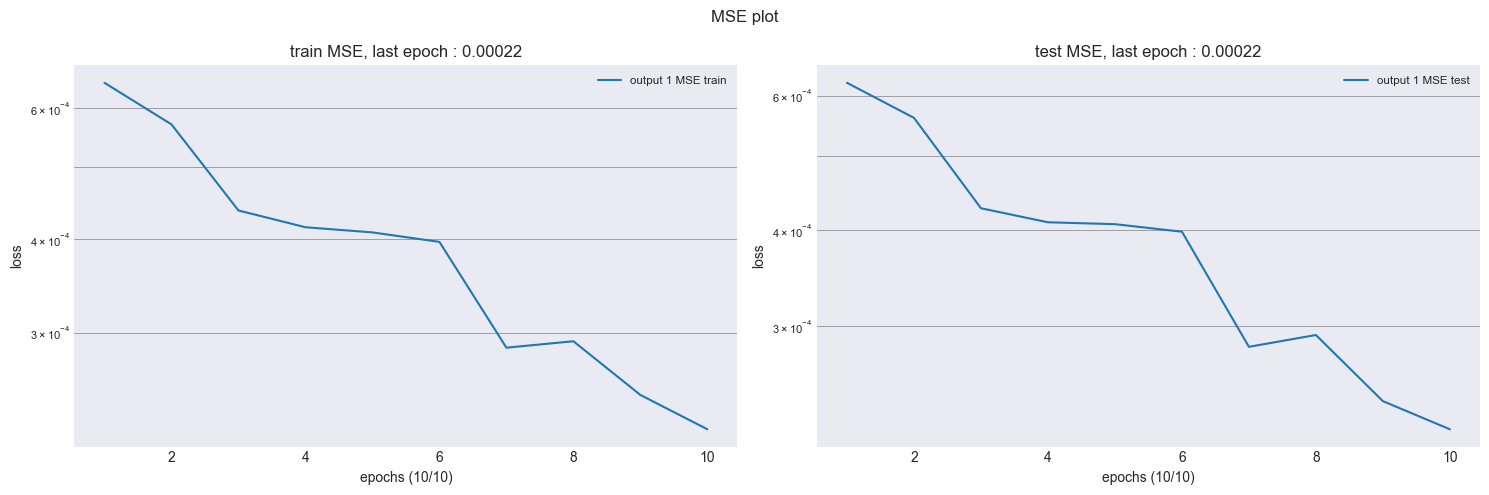

In [57]:
act = ['flex_elu0.2#0.9']
act.append('lin')
lyr = [n_feature, 4, n_output]
NN = MLP(lyr, act) #, data_type='float32')
# np.random.seed(42)
rates = {'adaptive_rate': True, 'learning_rate': 0.02,\
          'alpha': 0.0005, 'beta': 0, "gradient_clip": 1,\
              'eta_g': [0.001], 'eta_lan': [0.005], 'eta_rate': 0.0002,\
                  'eta_lan_rate': 0.001, 'eta_g_rate': 0.0004}
stack_variances = {'input_variance': 0.01, 'output_variance_chance': 0.01, 'hidden_stack_variance': [0.001]}
datas = [train_data, test_data, train_tar, test_tar]
loss_train, loss_test = [], []
loss_both = [loss_train, loss_test]
loss_both = NN.train(datas, rates, loss_both, epoch=10,\
                      stack_variances=stack_variances, one_mse=False) #, figsize=(15, 5))

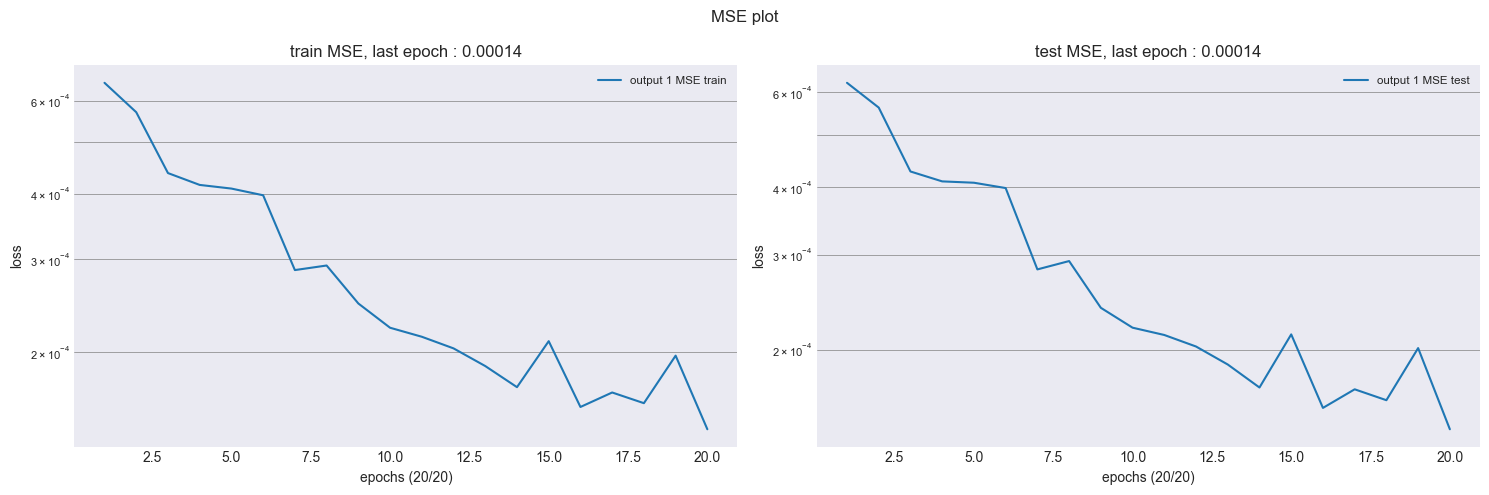

In [58]:
# print(NN.act_fun)
loss_both = NN.train(datas, rates, loss_both, epoch=10,\
                      stack_variances=stack_variances, one_mse=False)

examine trained network on data

In [59]:
train_predict = np.reshape([NN(i) for i in train_data], (-1, n_output))
test_predict = np.reshape([NN(i) for i in test_data], (-1, n_output))
whole_predict = np.reshape([NN(i) for i in input], (-1, n_output))

## **classification problem**

importing and working on data

In [153]:
data2 = pd.read_excel(path_class, header=None).to_numpy()
one_hot_encoded, unique_labels = one_hot_encoder(data2)
unique_labels.astype('int32')
input2 = normalizeData_neg1TOpos1(data2[:, :-1])
tar2 = one_hot_encoded
n_feature2 = np.size(input2, axis=1)
n_class = np.size(unique_labels)
train_data2, test_data2, train_tar2, test_tar2 = train_test_split(\
      input2, tar2, train_size=0.7, shuffle=True)

building neural network and training

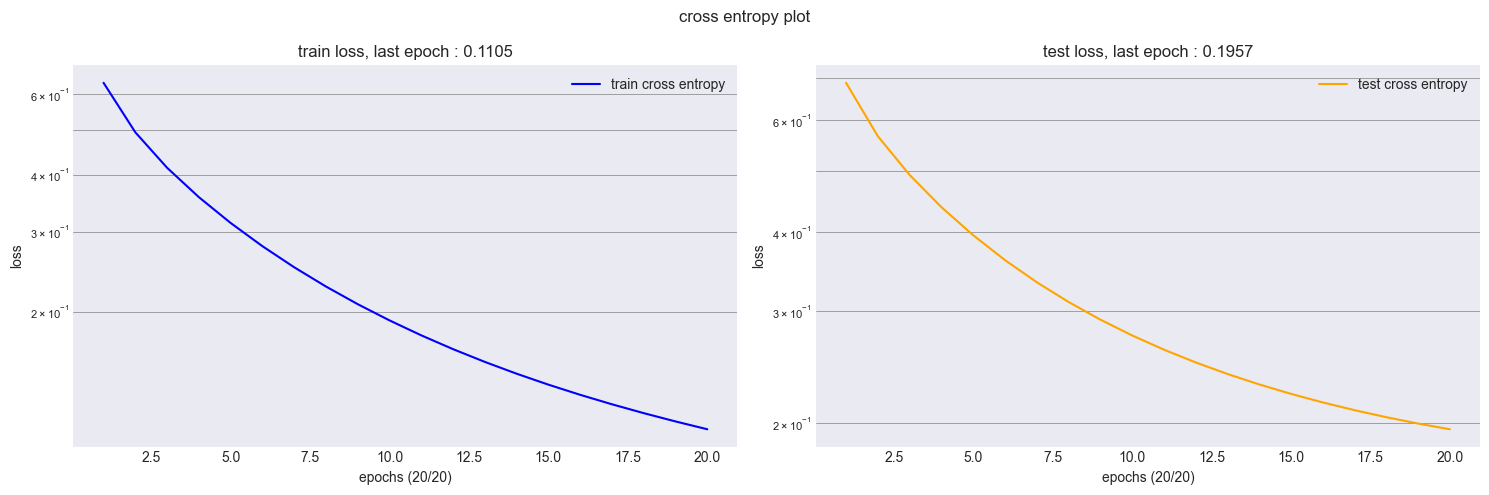

In [159]:
act = ['flex_tanh0.9']
act.append('softmax')
lyr = [n_feature2, 6, n_class]
NN2 = MLP(lyr, act) # data_type='float32')
# np.random.seed(42)
rates = {'adaptive_rate': True, 'learning_rate': 0.02, 'method': 'emotion', 'K1': 0.8, 'K2': 0.2,\
          'alpha': 0.001, 'beta': 0.0005,\
              'eta_g': 0.005, 'eta_g_rate': 0.001, 'eta_rate': 0.0008}
stack_variances2 = None
datas2 = [train_data2, test_data2, train_tar2, test_tar2]
loss_train2, loss_test2 = [], []
loss_both2 = [loss_train2, loss_test2]
loss_both2 = NN2.train(datas2, rates, loss_both2, epoch=20, stack_variances=None) #, figsize=(15, 5))

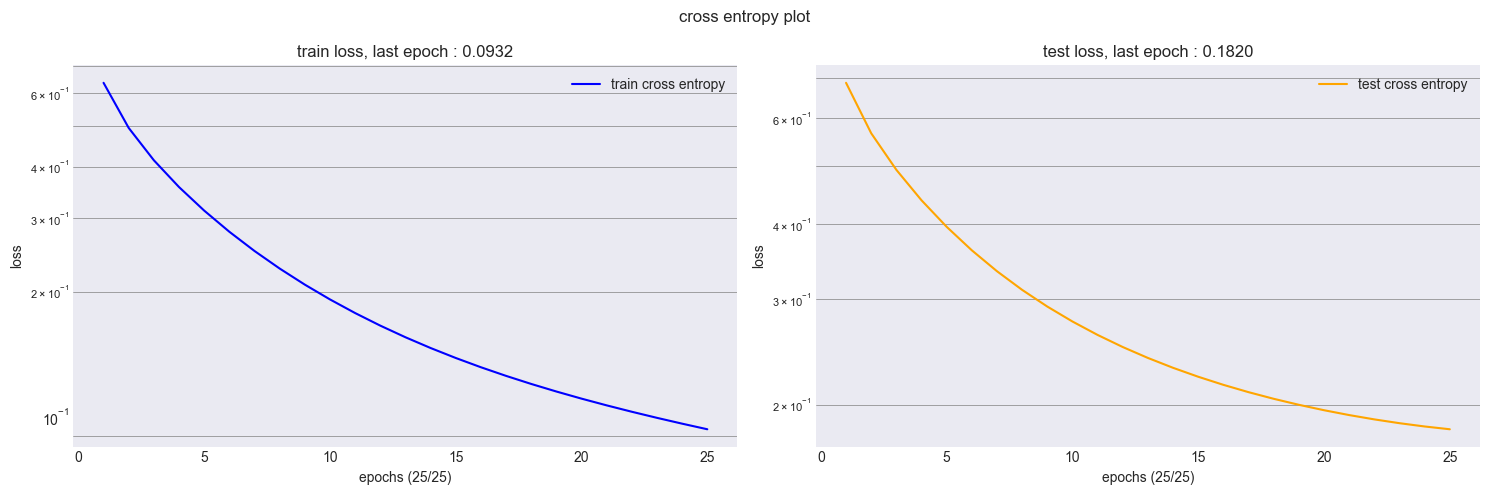

In [162]:
loss_both2 = NN2.train(datas2, rates, loss_both2, epoch=5, stack_variances=None) #, figsize=(15, 5))

examine trained network on data

In [160]:
train_predict2 = np.reshape([NN2(i) for i in train_data2], (-1, n_class))
test_predict2 = np.reshape([NN2(i) for i in test_data2], (-1, n_class))
whole_predict2 = np.reshape([NN2(i) for i in input2], (-1, n_class))

## **working with results**

regression:
regression plot for both test and train and also for each output

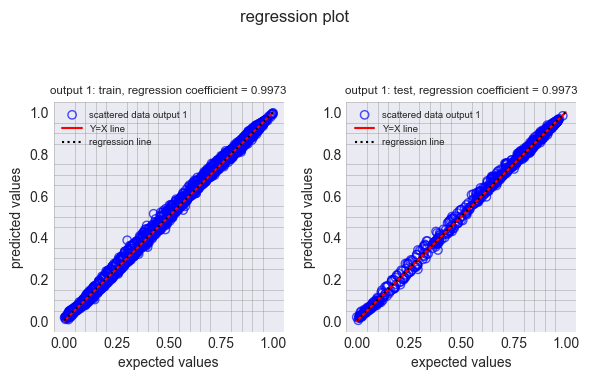

In [60]:
plot_regression(train_tar, train_predict, test_tar, test_predict, is0to1=True, figsize=(6, 4))

plot targets and outputs on same window, also separatly for each output

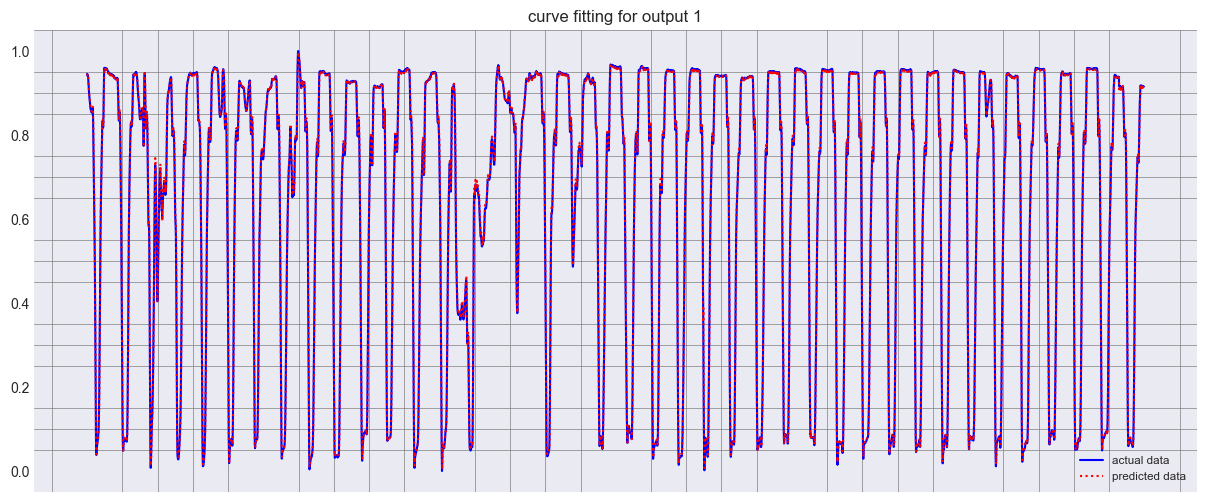

In [61]:
plot_outputs(tar, whole_predict, figsize=(15, 6))

classification
plot confusion matrix

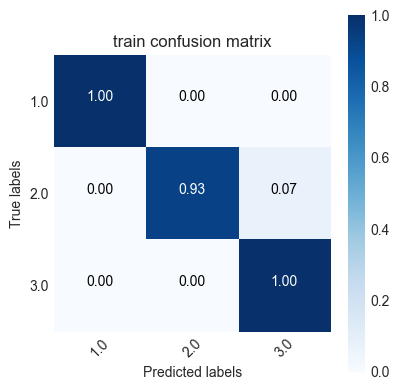

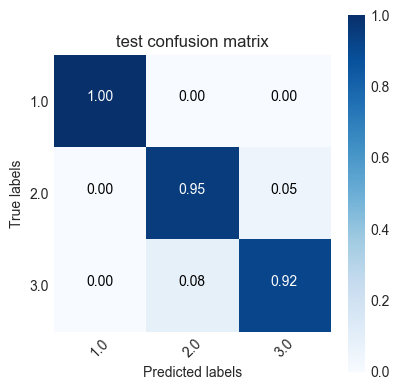

In [163]:
plot_confusion_matrix(train_tar2, train_predict2, unique_labels, title='train confusion matrix', normalize=True, figsize=(4, 4))
plot_confusion_matrix(test_tar2, test_predict2, unique_labels, title='test confusion matrix', normalize=True, figsize=(4, 4))

plot classification data

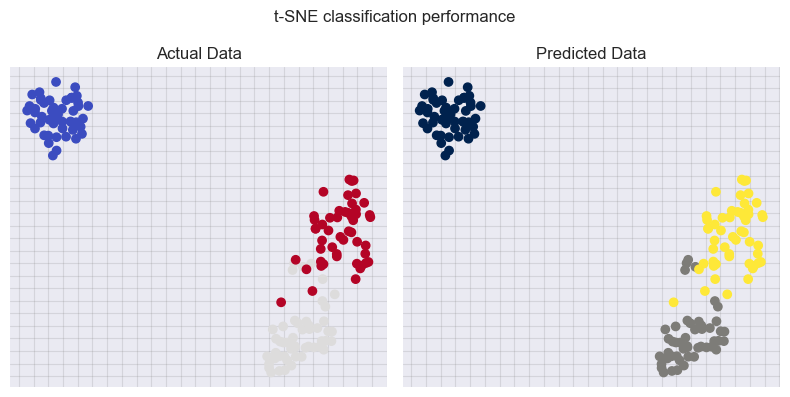

In [164]:
visualize_data(input2, tar2, whole_predict2, figsize=(8, 4))